In [1]:
import requests
import json
import urllib.parse
import sys
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class Disease:
    """
    Description: A class to represent a disease.
    """
    def __init__(self, name):
        self.name = name

    def __str__(self):
        return self.name

    def find_genes(self, species):
        """
        Description: Find the genes associated with the disease.
        Query MyGene.info to find the associated gene symbols.
        :return: A list of gene symbols
        """
        # Define the API endpoint
        mygene_url = 'http://mygene.info/v3/query'
        # Define the API parameters
        mygene_params = {
            'q': self.name,
            'fields': 'symbol,name,summary',
            'species': species,
            'size': 10  # maximum number of results to return
            }
        # Send the GET request to the API and retrieve the response
        mygene_response = requests.get(mygene_url, params=mygene_params)
        # Check if the request was successful
        if not mygene_response.ok:
            # Raise an exception if the request was unsuccessful
            mygene_response.raise_for_status()
        # Retrieve the JSON data from the response
        mygene_data = mygene_response.json()
        genes = []
        # Extract gene information from the response
        for res in mygene_data['hits']:
            gene_symbol = res['symbol']
            genes.append(Gene(species, gene_symbol))
        return genes

In [3]:
class Gene:
    """
    Description: A class to represent a gene.
    """

    def __init__(self, species, symbol, id=None):
        self.species = species
        self.symbol = symbol
        if id is None:
            self.id = self.get_id()
        else:
            self.id = id

    def __str__(self):
        return self.species + ' - ' + self.symbol + ' - ' + self.id

    def get_id(self):
        """
        ATTENTION: ONLY WORKS FOR HUMAN GENES!
        DOUBLE ATTENTION: IT DOESN'T WORK FOR MANY GENE SYMBOLS!
        Description: Gets the Ensembl gene ID from the gene symbol.
        Query Ensembl to convert the gene symbol to an Ensembl gene ID.
        :return: An Ensembl gene ID
        """
        ensembl_url = 'https://rest.ensembl.org/xrefs/symbol/homo_sapiens/'
        # Define the API parameters
        ensembl_params = {
            'content-type': 'application/json',
            'object_type': 'gene',
            'ensembl_release': 'GRCh38'
        }
        # Send the GET request to the API and retrieve the response
        ensembl_response = requests.get(ensembl_url + self.symbol, params=ensembl_params)
        # Check if the request was successful
        if not ensembl_response.ok:
            # Raise an exception if the request was unsuccessful
            ensembl_response.raise_for_status()
        # Retrieve the JSON data from the response
        ensembl_data = ensembl_response.json()
        # Raise an exception if no Ensembl gene ID was found or multiple Ensembl gene IDs were found
        if len(ensembl_data) == 0:
            # Raise an exception that no Ensembl gene ID was found
            raise Exception('No Ensembl gene ID was found for the gene symbol: ' + self.symbol)
        # There might be multiple Ensembl gene IDs for the gene symbol, but we are ignoring it
        # We are returning only the first Ensembl gene ID
        return ensembl_data[0]['id']

    def get_orthologues(self, target_species):
        """
        Description: Gets the orthologues of the gene for the species of interest.
        :param species1: The species of the starting gene
        :param species2: The species of the orthologues
        :return:
        """
        homology_url = 'https://rest.ensembl.org/homology/id/'
        # Define the API parameters
        params = {
            'content-type': 'application/json',
            'type': 'orthologues',
            'target_species': target_species
        }
        # Send the GET request to the API and retrieve the response
        homology_response = requests.get(homology_url + self.id, params=params)
        # Check if the request was successful
        if not homology_response.ok:
            # Raise an exception if the request was unsuccessful
            homology_response.raise_for_status()
        # Retrieve the JSON data from the response
        homology_data = homology_response.json()
        # Extract the orthologues gene IDs from the response
        for homology in homology_data["data"][0]["homologies"]:
            if homology['type'] == 'ortholog_one2one':
                return Gene(target_species, self.symbol, homology["target"]["id"])
        return None

    def get_proteins(self):
        """
        Description: Gets the proteins of the gene.
        Query UniProt to get the proteins of the gene.
        :return:
        """
        # Use UniProt to find the proteins produced by the orthologues
        uniprot_url = f"https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=json&query=%28{self.species}%20{self.id}%29"
        uniprot_response = requests.get(uniprot_url)
        # Check if the request was successful\
        if not uniprot_response.ok:
            # Raise an exception if the request was unsuccessful
            uniprot_response.raise_for_status()
        # convert response.content from bytes to dictionary
        data = json.loads(uniprot_response.content)
        # If the data is empty, skip it
        if len(data["results"]) == 0:
            return None
        return Protein(self.species, self.symbol, data["results"][0]["primaryAccession"], data["results"][0]["sequence"]["value"])

In [4]:
class Protein:
    """
    Description: A class to represent a protein.
    """
    def __init__(self, species, name, uniprot_id, sequence):
        self.species = species
        self.name = name
        self.uniprot_id = uniprot_id
        self.sequence = sequence

    def __str__(self):
        return self.species + ' - ' + self.name + ' - ' + self.uniprot_id + ' - ' + self.sequence

In [27]:
# Save the data for Knowledge Graph

disease_list = [Disease('bipolar disorder'), Disease('high blood pressure'), Disease('cardiovascular disease'), Disease('Rheumatoid arthritis'), Disease('Anxiety disorders'), 
                Disease('Sickle Cell'), Disease('Arrhythmia'), Disease('cad'), Disease('stroke'), Disease('copd')]
data = {}
for disease in disease_list:
    data[disease.name] = {}
    data[disease.name]['human_gene'] = {}
    data[disease.name]['mouse_gene'] = {}
    data[disease.name]['human_protein'] = {}
    data[disease.name]['mouse_protein'] = {}
    h_genes = []
    h_proteins = []
    m_genes = []
    m_proteins = []
    for h_gene in disease.find_genes('human'):
        m_gene = h_gene.get_orthologues('mus_musculus')
        if m_gene is not None:
            h_genes.append(h_gene)
            m_genes.append(m_gene)
            m_protein = m_gene.get_proteins()
            m_proteins.append(m_protein)
            h_protein = h_gene.get_proteins()
            h_proteins.append(h_protein)
    data[disease.name]['human_gene'] = [(h_gene.symbol, h_gene.id) for h_gene in h_genes]
    data[disease.name]['mouse_gene'] = [(m_gene.symbol, m_gene.id) for m_gene in m_genes]
    data[disease.name]['human_protein'] = [(h_protein.name, h_protein.uniprot_id, h_protein.sequence) for h_protein in h_proteins]
    data[disease.name]['mouse_protein'] = [(m_protein.name, m_protein.uniprot_id, m_protein.sequence) for m_protein in m_proteins]

In [31]:
# Create an empty graph
M = nx.Graph()

# Read mock dataset
# iterate through keys of the dictionary (disease)
for disease in data.keys():
    M.add_node(disease, type="Disease") # print disease name
    disease_data = data[disease]  # get the dictionary of the disease, which contains the gene and protein data
    for element in disease_data.keys():  # iterate through the keys of the disease dictionary, i.e. the gene and protein data
        # print(element)  # print the key of the dictionary, e.g. human_gene
        species_type, type = element.split('_')  # split the key into species and type
        # print(species, type)
        element_list = disease_data[element]  # get the list of genes or proteins
        #print(len(element_list)) 
        for i, item in enumerate(element_list):  # iterate through the list of genes or proteins
            # print(item)
            if type == 'gene':  # if the type is gene, then the item is a tuple of gene symbol and gene id
                gene_symbol, gene_id = item
                #print(gene_id, gene_symbol, species_type)
                # check if node is already present in the graph
                if gene_id not in M.nodes:
                    M.add_node(gene_id, name = gene_symbol, species = species_type, type= "Gene") 
                if species_type == "human":
                    M.add_edge(gene_id, disease, type="Association")
                elif species_type == "mouse":
                    mouse_gene = data[disease][species_type + '_gene'][i]
                    human_gene = data[disease]['human_gene'][i]
                    M.add_edge(mouse_gene[1], human_gene[1], type="Orthology")

                # check if the gene is already present in the nodes of the graph
                #if gene_symbol in G.nodes:
                    # if the gene is already present, then add the disease as a node attribute
                   # G.nodes[gene_symbol]['disease'] = disease
                # print(gene_symbol, gene_id)
            elif type == 'protein':  # if the type is protein, then the item is a tuple of protein name, protein id and protein sequence
                protein_symbol, protein_id, protein_sequence = item 
                if protein_id not in M.nodes:
                    M.add_node(protein_id, name = protein_symbol, species = species_type, sequence = protein_sequence, type= "Protein") 
                gene_associated = data[disease][species_type + '_gene'][i]
                gene_id = gene_associated[1]
                M.add_edge(protein_id, gene_id, type="Expression")

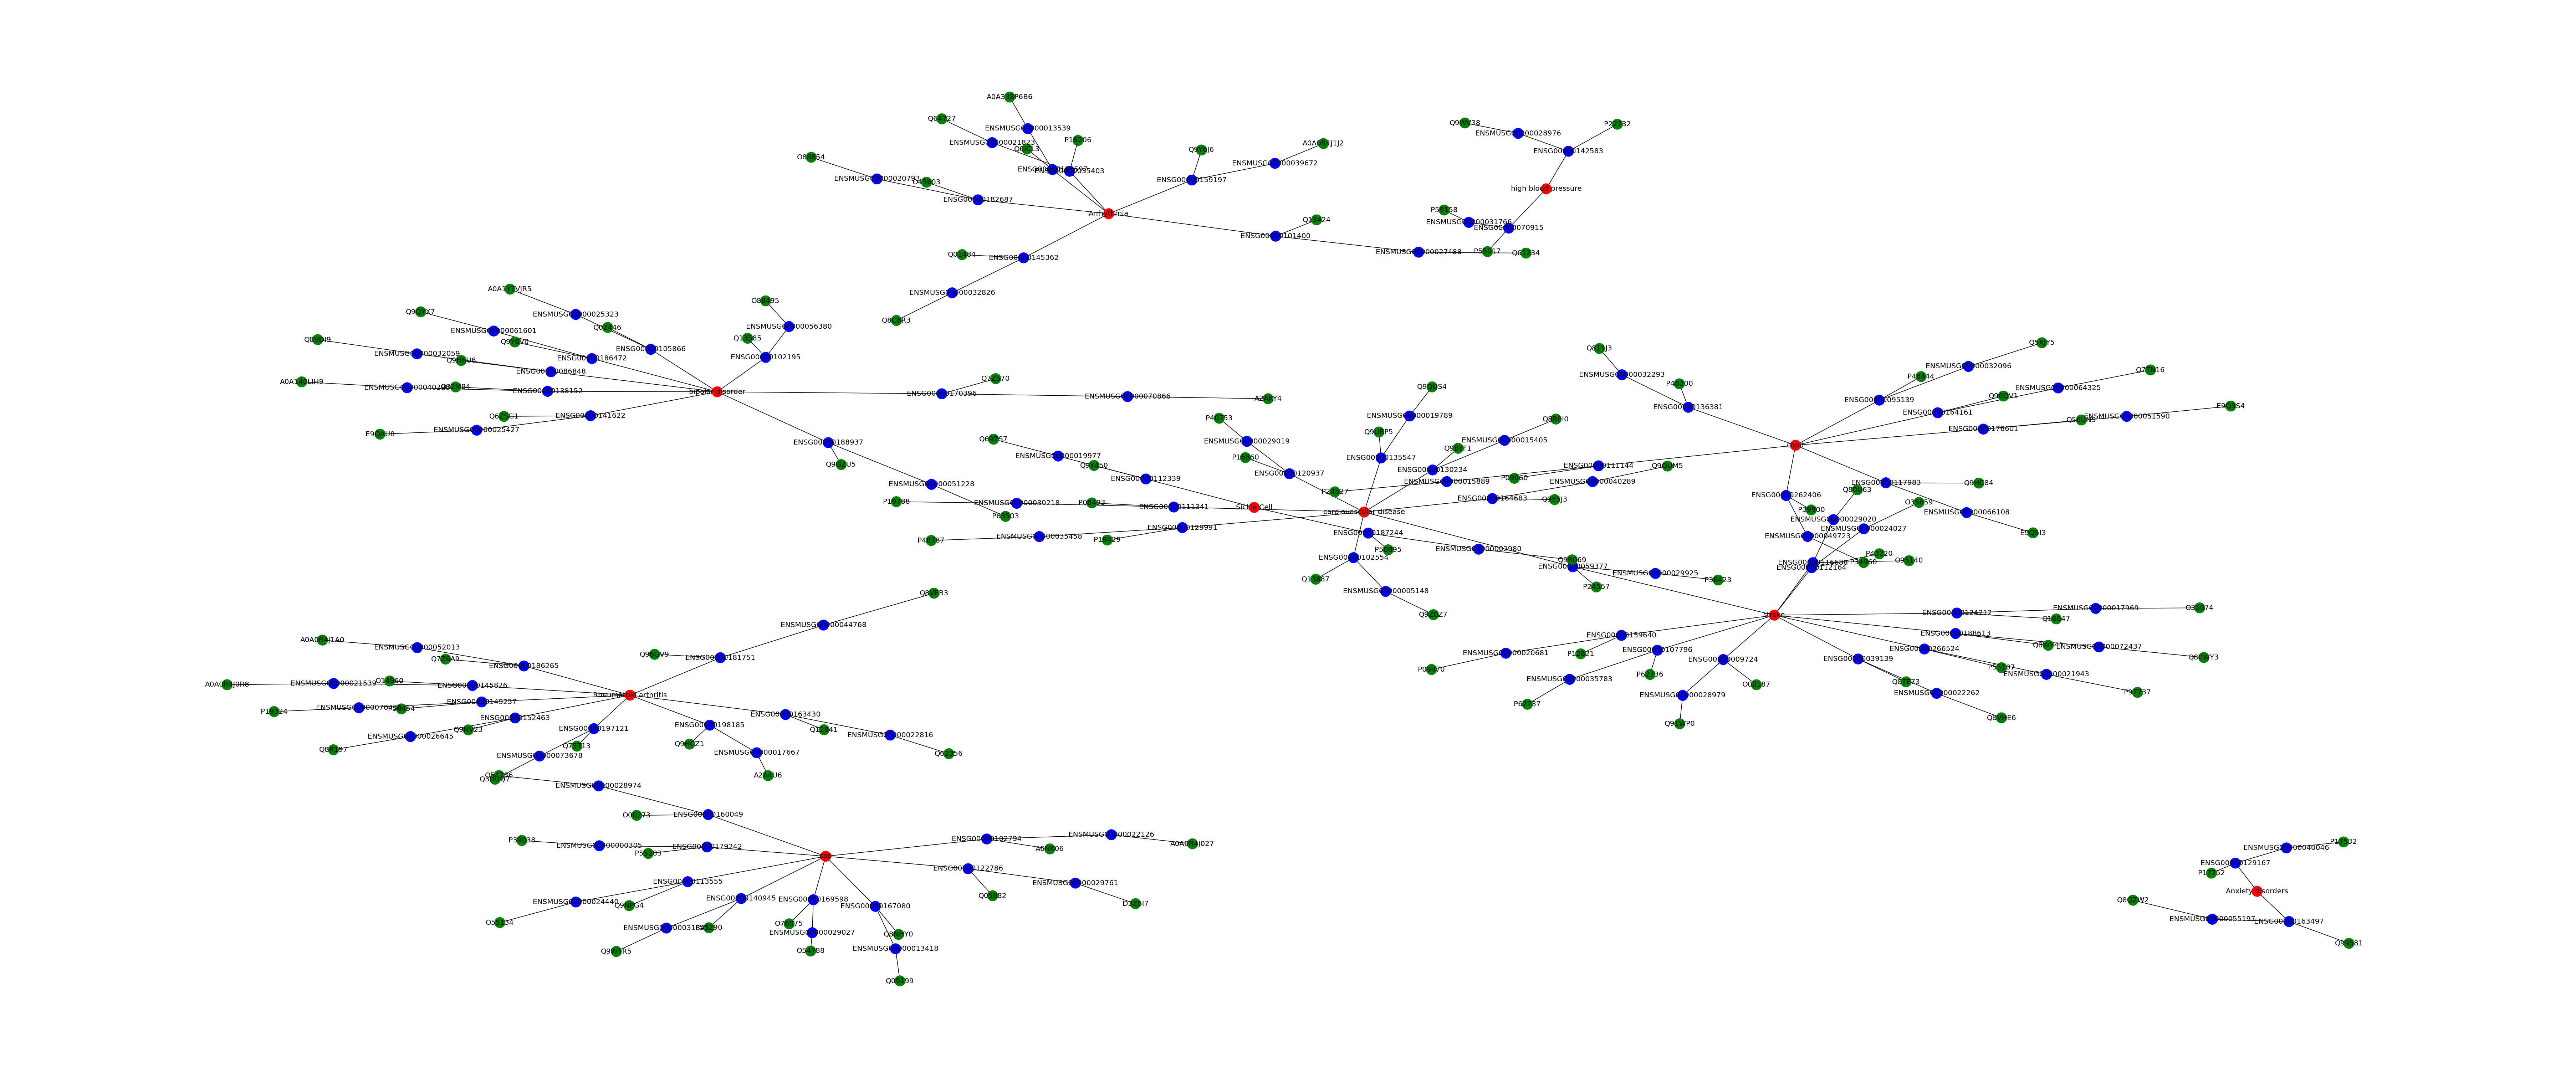

In [32]:
color_map = {'Gene': 'blue', 'Protein': 'green', 'Disease': 'red'}

# Create a list of colors for the nodes based on their type
node_colors = [color_map[M.nodes[n]['type']] for n in M.nodes()]

# Draw the graph
#nx.draw(M, with_labels=True, node_color=node_colors, font_color='white')
#nx.draw(M, with_labels=True, node_color=node_colors, font_color='white', figsize=(12,12),node_size=60,font_size=8)
#nx.draw(G,pos,node_size=60,font_size=8, figsize=(12,12)) 

fig = plt.figure(1, figsize=(60, 25), dpi=120)
nx.draw(M, with_labels=True, font_weight='normal',node_color=node_colors,)

# Show the plot
plt.show()

In [33]:
nx.info(M)


'Graph with 250 nodes and 241 edges'

In [34]:
type_counts = {}
for n in M.nodes():
    node_type = M.nodes[n]["type"]
    if node_type in type_counts:
        type_counts[node_type] += 1
    else:
        type_counts[node_type] = 1

print(type_counts)

{'Disease': 10, 'Gene': 120, 'Protein': 120}


In [26]:
# list of all disease nodes in the graph
disease_nodes = [n for n in M.nodes() if M.nodes[n]["type"] == "Disease"]
print(disease_nodes)

['bipolar disorder', 'high blood pressure', 'cardiovascular disease', 'Rheumatoid arthritis', 'Anxiety disorders', 'Arrhythmia', 'cad', 'stroke', 'copd']
